<a href="https://colab.research.google.com/github/shadab4150/Mura-Stanford-Bone-Xray-abnormalities-detection/blob/master/file_processing_mura_stanford_bone_abnormalities_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchviz

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import * 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mmg
import seaborn as sns
from tqdm import tnrange,tqdm
import gc
from graphviz import Digraph
import torch
from torch.autograd import Variable
from torchviz import make_dot

In [2]:
path = Path('/content/');path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/mura_xray'),
 PosixPath('/content/MURA-v1.1'),
 PosixPath('/content/final_mura_tr_vl.csv'),
 PosixPath('/content/mura_final_process.csv'),
 PosixPath('/content/drive'),
 PosixPath('/content/models'),
 PosixPath('/content/.ipynb_checkpoints'),
 PosixPath('/content/sample_data')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/Dataset/MURA-v1.1.zip' -d '/content/'

# Preprocessing training set

In [0]:
tp = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv',sep='/',header=None)
tl = pd.read_csv('/content/MURA-v1.1/train_labeled_studies.csv',sep='/',header=None)

## This dataframe contains paths of training images

In [63]:
tp.head(3)

,0,1,2,3,4,5
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image1.png
1,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image2.png
2,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image3.png


## This dataframe contains label of training images

In [64]:
tl.head(3)

,0,1,2,3,4,5
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,",1"
1,MURA-v1.1,train,XR_SHOULDER,patient00002,study1_positive,",1"
2,MURA-v1.1,train,XR_SHOULDER,patient00003,study1_positive,",1"


## creating a single path columns from all columns

In [88]:
paths = []
for i in tnrange(tp.shape[0],desc='row'):
    p = "/".join(str(x) for x in tp.iloc[i].values)
    paths.append(p)

In [0]:
tp['path'] = paths

In [0]:
tp.columns = ['folder','set','body_part','patient_id','study_PN','image_id','path']
tl.columns = ['folder','set','body_part','patient_id','study_PN','target']

In [91]:
tp.head(2)

,folder,set,body_part,patient_id,study_PN,image_id,path
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...


In [92]:
tl.head(2)

,folder,set,body_part,patient_id,study_PN,target
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,",1"
1,MURA-v1.1,train,XR_SHOULDER,patient00002,study1_positive,",1"


In [0]:
def label(x):
    if x==',1':
        return 1
    elif x==',0':
        return 0

In [0]:
tl['target']=tl['target'].apply(label,convert_dtype=True)

* Merging both **path** and **target**

In [0]:
total = pd.merge(tp,tl,left_on=['folder','set','body_part','patient_id','study_PN'],right_on=['folder','set','body_part','patient_id','study_PN'],how='left')

In [112]:
total.head()

,folder,set,body_part,patient_id,study_PN,image_id,path,target
0,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1,train,XR_SHOULDER,patient00001,study1_positive,image3.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1,train,XR_SHOULDER,patient00002,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1,train,XR_SHOULDER,patient00002,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1


## Creating one hot encoded for each body part

In [74]:
total_new = pd.get_dummies(total,columns=['body_part']);total_new.head()

,folder,set,patient_id,study_PN,image_id,path,target,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
0,MURA-v1.1,train,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
1,MURA-v1.1,train,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
2,MURA-v1.1,train,patient00001,study1_positive,image3.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
3,MURA-v1.1,train,patient00002,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0
4,MURA-v1.1,train,patient00002,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0


# Preprocessing validation set

In [0]:
vp = pd.read_csv('/content/MURA-v1.1/valid_image_paths.csv',sep='/',header=None)  ## This dataframe contains paths of validation images
vl = pd.read_csv('/content/MURA-v1.1/valid_labeled_studies.csv',sep='/',header=None) ## This dataframe contains label of validation images

* Creating a single path columns from all columns

In [116]:
pathsv = []   
for i in tnrange(vp.shape[0],desc='row'):
    p = "/".join(str(x) for x in vp.iloc[i].values)
    pathsv.append(p)

In [0]:
vp['path'] = pathsv

In [0]:
vp.columns = ['folder','set','body_part','patient_id','study_PN','image_id','path']
vl.columns = ['folder','set','body_part','patient_id','study_PN','target']

In [0]:
vl['target']=vl['target'].apply(label,convert_dtype=True)

* Merging both **path** and **target**

In [0]:
totalv = pd.merge(vp,vl,left_on=['folder','set','body_part','patient_id','study_PN'],right_on=['folder','set','body_part','patient_id','study_PN'],how='left')

In [126]:
totalv.head()

,folder,set,body_part,patient_id,study_PN,image_id,path,target
0,MURA-v1.1,valid,XR_WRIST,patient11185,study1_positive,image1.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1,valid,XR_WRIST,patient11185,study1_positive,image2.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
2,MURA-v1.1,valid,XR_WRIST,patient11185,study1_positive,image3.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
3,MURA-v1.1,valid,XR_WRIST,patient11185,study1_positive,image4.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
4,MURA-v1.1,valid,XR_WRIST,patient11186,study1_positive,image1.png,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1


## Creating one hot encoded for each body part

In [81]:
totalv_new = pd.get_dummies(totalv,columns=['body_part']);totalv_new.head()

,folder,set,patient_id,study_PN,image_id,path,target,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
0,MURA-v1.1,valid,patient11185,study1_positive,image1.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0,0,0,0,0,0,1
1,MURA-v1.1,valid,patient11185,study1_positive,image2.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0,0,0,0,0,0,1
2,MURA-v1.1,valid,patient11185,study1_positive,image3.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0,0,0,0,0,0,1
3,MURA-v1.1,valid,patient11185,study1_positive,image4.png,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,0,0,0,0,0,0,1
4,MURA-v1.1,valid,patient11186,study1_positive,image1.png,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,0,0,0,0,0,0,1


# Final combining both Training and Validation into single dataframe

In [0]:
final12 = pd.concat([total,totalv]);

In [0]:
final12.to_csv('mura_final_combined.csv',index=False)

In [332]:
final12.head()

,folder,is_valid,body_part,patient_id,study_PN,image_id,path,target
0,MURA-v1.1,False,XR_SHOULDER,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1,False,XR_SHOULDER,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1,False,XR_SHOULDER,patient00001,study1_positive,image3.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1,False,XR_SHOULDER,patient00002,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1,False,XR_SHOULDER,patient00002,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1


In [0]:
mura = final12[['is_valid','body_part','path','target']].copy()

In [343]:
for bodypart in mura.body_part.unique():
  print(bodypart+" : "+str(mura[mura['body_part']==bodypart].shape[0]))

XR_SHOULDER : 8942
XR_HUMERUS : 1560
XR_FINGER : 5567
XR_ELBOW : 5396
XR_WRIST : 10411
XR_FOREARM : 2126
XR_HAND : 6003


In [0]:
mura.to_csv('mura_final_4col.csv',index=False)

In [0]:
!cp '/content/mura_final_combined.csv' '/content/drive/My Drive/Dataset/'
!cp '/content/mura_final_4col.csv' '/content/drive/My Drive/Dataset/'

In [82]:
final = pd.concat([total_new,totalv_new]);final.head()

,folder,set,patient_id,study_PN,image_id,path,target,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
0,MURA-v1.1,train,patient00001,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
1,MURA-v1.1,train,patient00001,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
2,MURA-v1.1,train,patient00001,study1_positive,image3.png,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,0,0,0,0,1,0
3,MURA-v1.1,train,patient00002,study1_positive,image1.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0
4,MURA-v1.1,train,patient00002,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,0,0,0,0,0,1,0


In [0]:
final.to_csv('final_mura_tr_vl.csv',index=False)

In [370]:
df = pd.read_csv('/content/drive/My Drive/Dataset/mura_final_onehot.csv');df.sample(n=5)

,folder,is_valid,patient_id,study_PN,image_id,path,target,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
238,MURA-v1.1,False,patient00075,study1_positive,image2.png,MURA-v1.1/train/XR_SHOULDER/patient00075/study...,1,0,0,0,0,0,1,0
13638,MURA-v1.1,False,patient04496,study1_negative,image3.png,MURA-v1.1/train/XR_FINGER/patient04496/study1_...,0,0,1,0,0,0,0,0
4344,MURA-v1.1,False,patient01414,study1_positive,image3.png,MURA-v1.1/train/XR_SHOULDER/patient01414/study...,1,0,0,0,0,0,1,0
6450,MURA-v1.1,False,patient02082,study1_negative,image1.png,MURA-v1.1/train/XR_SHOULDER/patient02082/study...,0,0,0,0,0,0,1,0
21381,MURA-v1.1,False,patient06787,study1_positive,image1.png,MURA-v1.1/train/XR_WRIST/patient06787/study1_p...,1,0,0,0,0,0,0,1


In [369]:
train = pd.read_csv('/content/drive/My Drive/Dataset/mura_final_4col.csv')
train.sample(n=10)

,is_valid,body_part,path,target
37514,True,XR_FOREARM,MURA-v1.1/valid/XR_FOREARM/patient11409/study1...,1
12073,False,XR_FINGER,MURA-v1.1/train/XR_FINGER/patient03947/study1_...,0
23274,False,XR_WRIST,MURA-v1.1/train/XR_WRIST/patient07256/study1_p...,1
39480,True,XR_ELBOW,MURA-v1.1/valid/XR_ELBOW/patient11869/study1_n...,0
18785,False,XR_ELBOW,MURA-v1.1/train/XR_ELBOW/patient06077/study1_n...,0
32830,False,XR_HAND,MURA-v1.1/train/XR_HAND/patient10139/study1_ne...,0
36039,False,XR_HAND,MURA-v1.1/train/XR_HAND/patient04854/study1_ne...,0
31386,False,XR_HAND,MURA-v1.1/train/XR_HAND/patient09766/study1_po...,1
14490,False,XR_FINGER,MURA-v1.1/train/XR_FINGER/patient04809/study1_...,0
32485,False,XR_HAND,MURA-v1.1/train/XR_HAND/patient10046/study1_po...,1


### Forming a validation set:
* As described in mura

In [0]:
def targ(x):
  if x==1:
    return 'abnormal'
  elif x==0:
    return 'normal'

In [0]:
df.target=df.target.apply(targ,convert_dtype=True)

In [374]:
df.sample(n=10)

,folder,is_valid,patient_id,study_PN,image_id,path,target,body_part_XR_ELBOW,body_part_XR_FINGER,body_part_XR_FOREARM,body_part_XR_HAND,body_part_XR_HUMERUS,body_part_XR_SHOULDER,body_part_XR_WRIST
17361,MURA-v1.1,False,patient05626,study1_negative,image1.png,MURA-v1.1/train/XR_ELBOW/patient05626/study1_n...,normal,1,0,0,0,0,0,0
30362,MURA-v1.1,False,patient08998,study2_negative,image2.png,MURA-v1.1/train/XR_FOREARM/patient08998/study2...,normal,0,0,1,0,0,0,0
15767,MURA-v1.1,False,patient05173,study1_positive,image4.png,MURA-v1.1/train/XR_ELBOW/patient05173/study1_p...,abnormal,1,0,0,0,0,0,0
3545,MURA-v1.1,False,patient01145,study2_negative,image1.png,MURA-v1.1/train/XR_SHOULDER/patient01145/study...,normal,0,0,0,0,0,1,0
10291,MURA-v1.1,False,patient03404,study1_positive,image2.png,MURA-v1.1/train/XR_FINGER/patient03404/study1_...,abnormal,0,1,0,0,0,0,0
33603,MURA-v1.1,False,patient10329,study1_negative,image1.png,MURA-v1.1/train/XR_HAND/patient10329/study1_ne...,normal,0,0,0,1,0,0,0
2088,MURA-v1.1,False,patient00660,study2_negative,image3.png,MURA-v1.1/train/XR_SHOULDER/patient00660/study...,normal,0,0,0,0,0,1,0
22966,MURA-v1.1,False,patient05714,study1_positive,image2.png,MURA-v1.1/train/XR_WRIST/patient05714/study1_p...,abnormal,0,0,0,0,0,0,1
2927,MURA-v1.1,False,patient00933,study1_positive,image4.png,MURA-v1.1/train/XR_SHOULDER/patient00933/study...,abnormal,0,0,0,0,0,1,0
23060,MURA-v1.1,False,patient00328,study1_positive,image3.png,MURA-v1.1/train/XR_WRIST/patient00328/study1_p...,abnormal,0,0,0,0,0,0,1


In [0]:
cols_onehot = ['target',
       'body_part_XR_ELBOW', 'body_part_XR_FINGER', 'body_part_XR_FOREARM',
       'body_part_XR_HAND', 'body_part_XR_HUMERUS', 'body_part_XR_SHOULDER',
       'body_part_XR_WRIST']

## X-ray images of different body parts normal

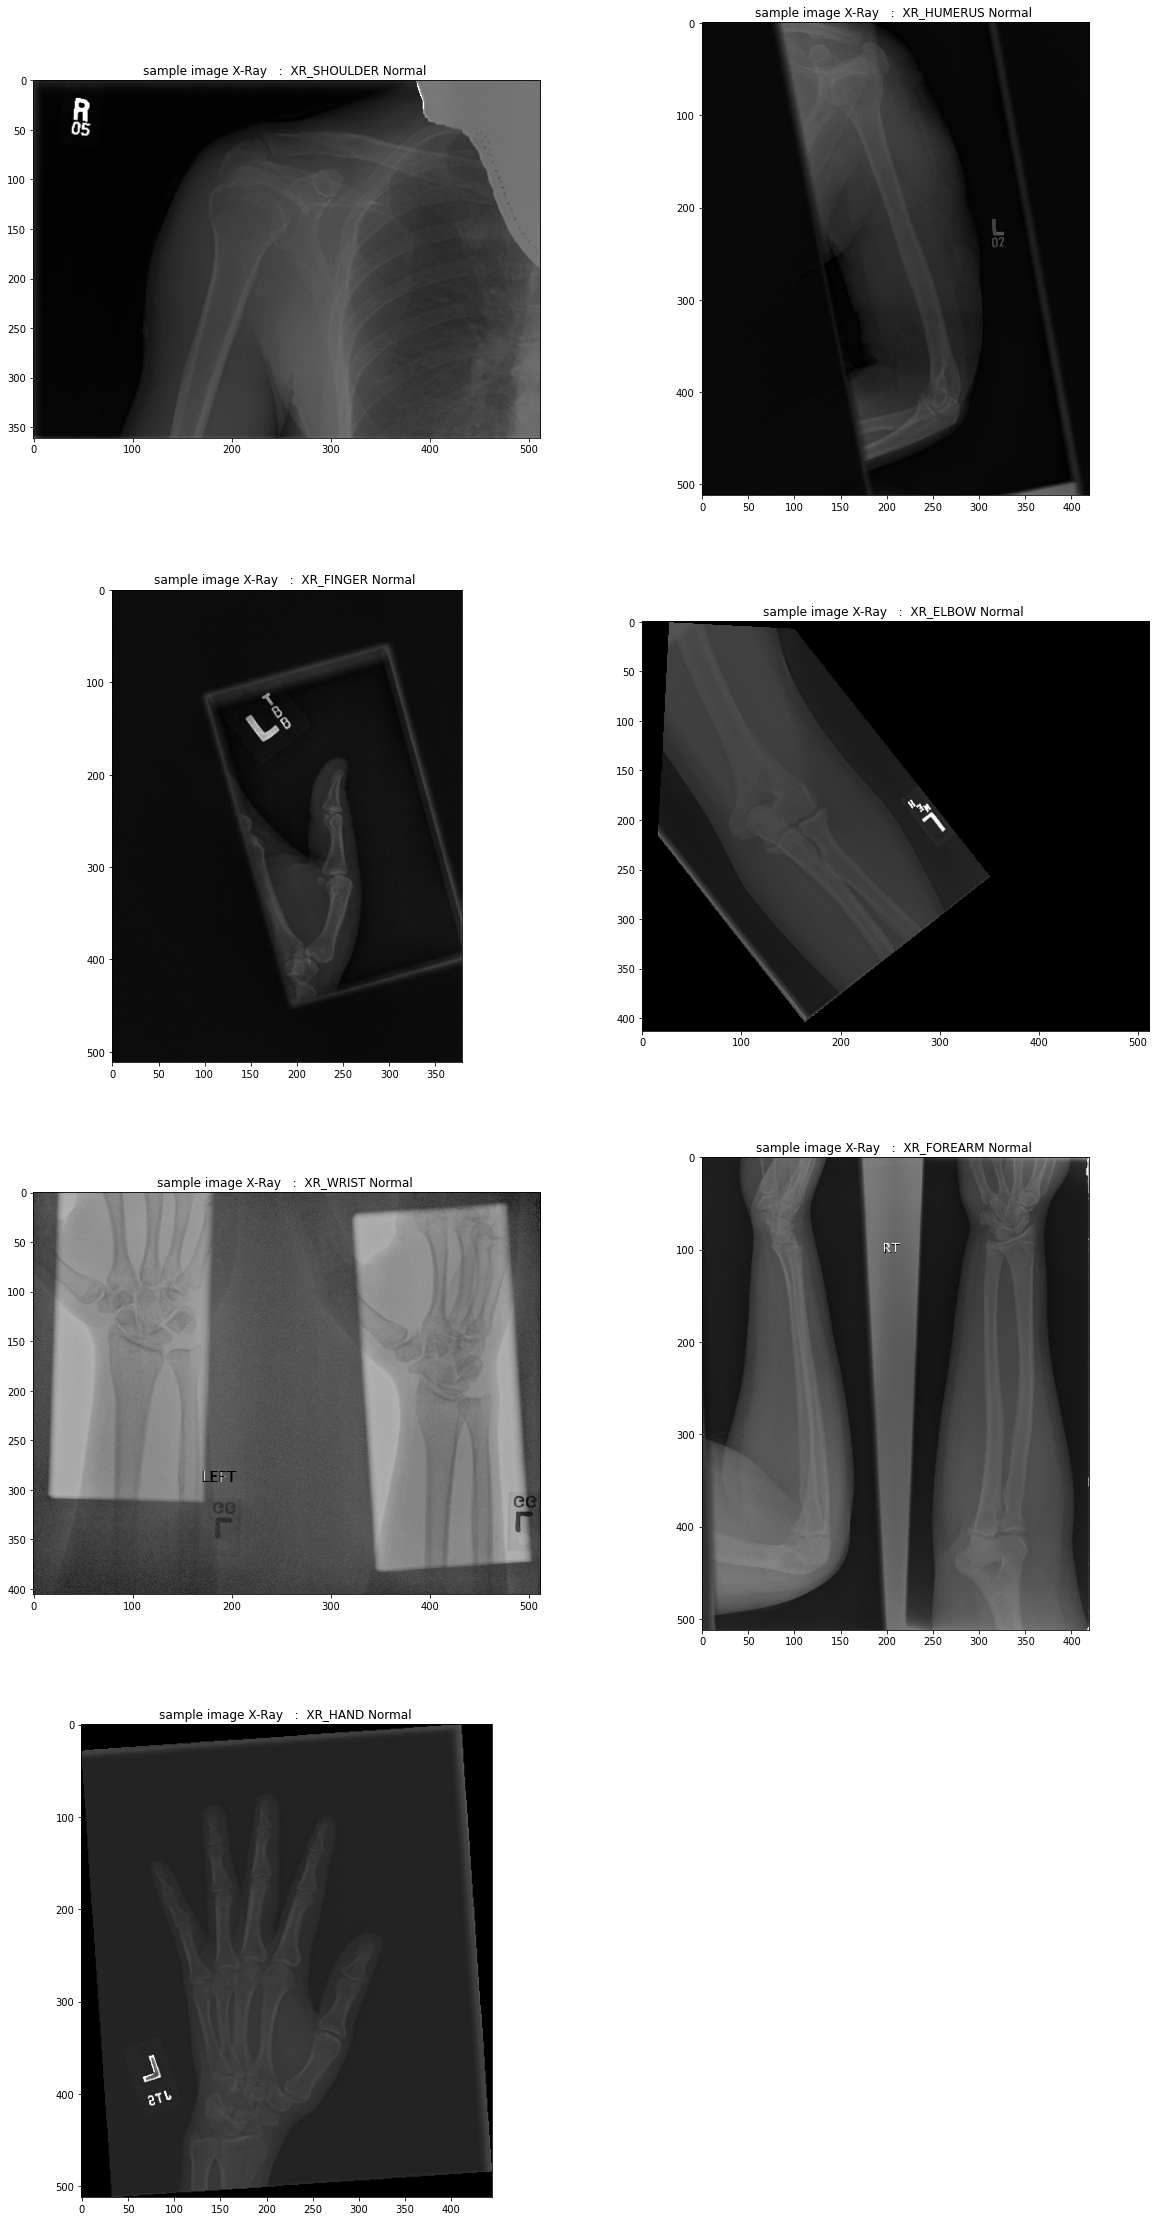

In [456]:
plt.figure(1,figsize=(20,40))
it = 0
for i in train.body_part.unique():
  plt.subplot(421+it)
  k=train[(train['body_part']==i)&(train['target']==0)]
  #img =open_image(path/k.path.iloc[0])
  img = mmg.imread(str(path/k.path.iloc[0]))
  plt.imshow(img,cmap='gray')
  shp = " ".join(str(x) for x in list(img.shape))
  plt.title('sample image X-Ray   :  ' +i + " Normal ")
  it+=1

## X-ray images of different body parts Abnormal

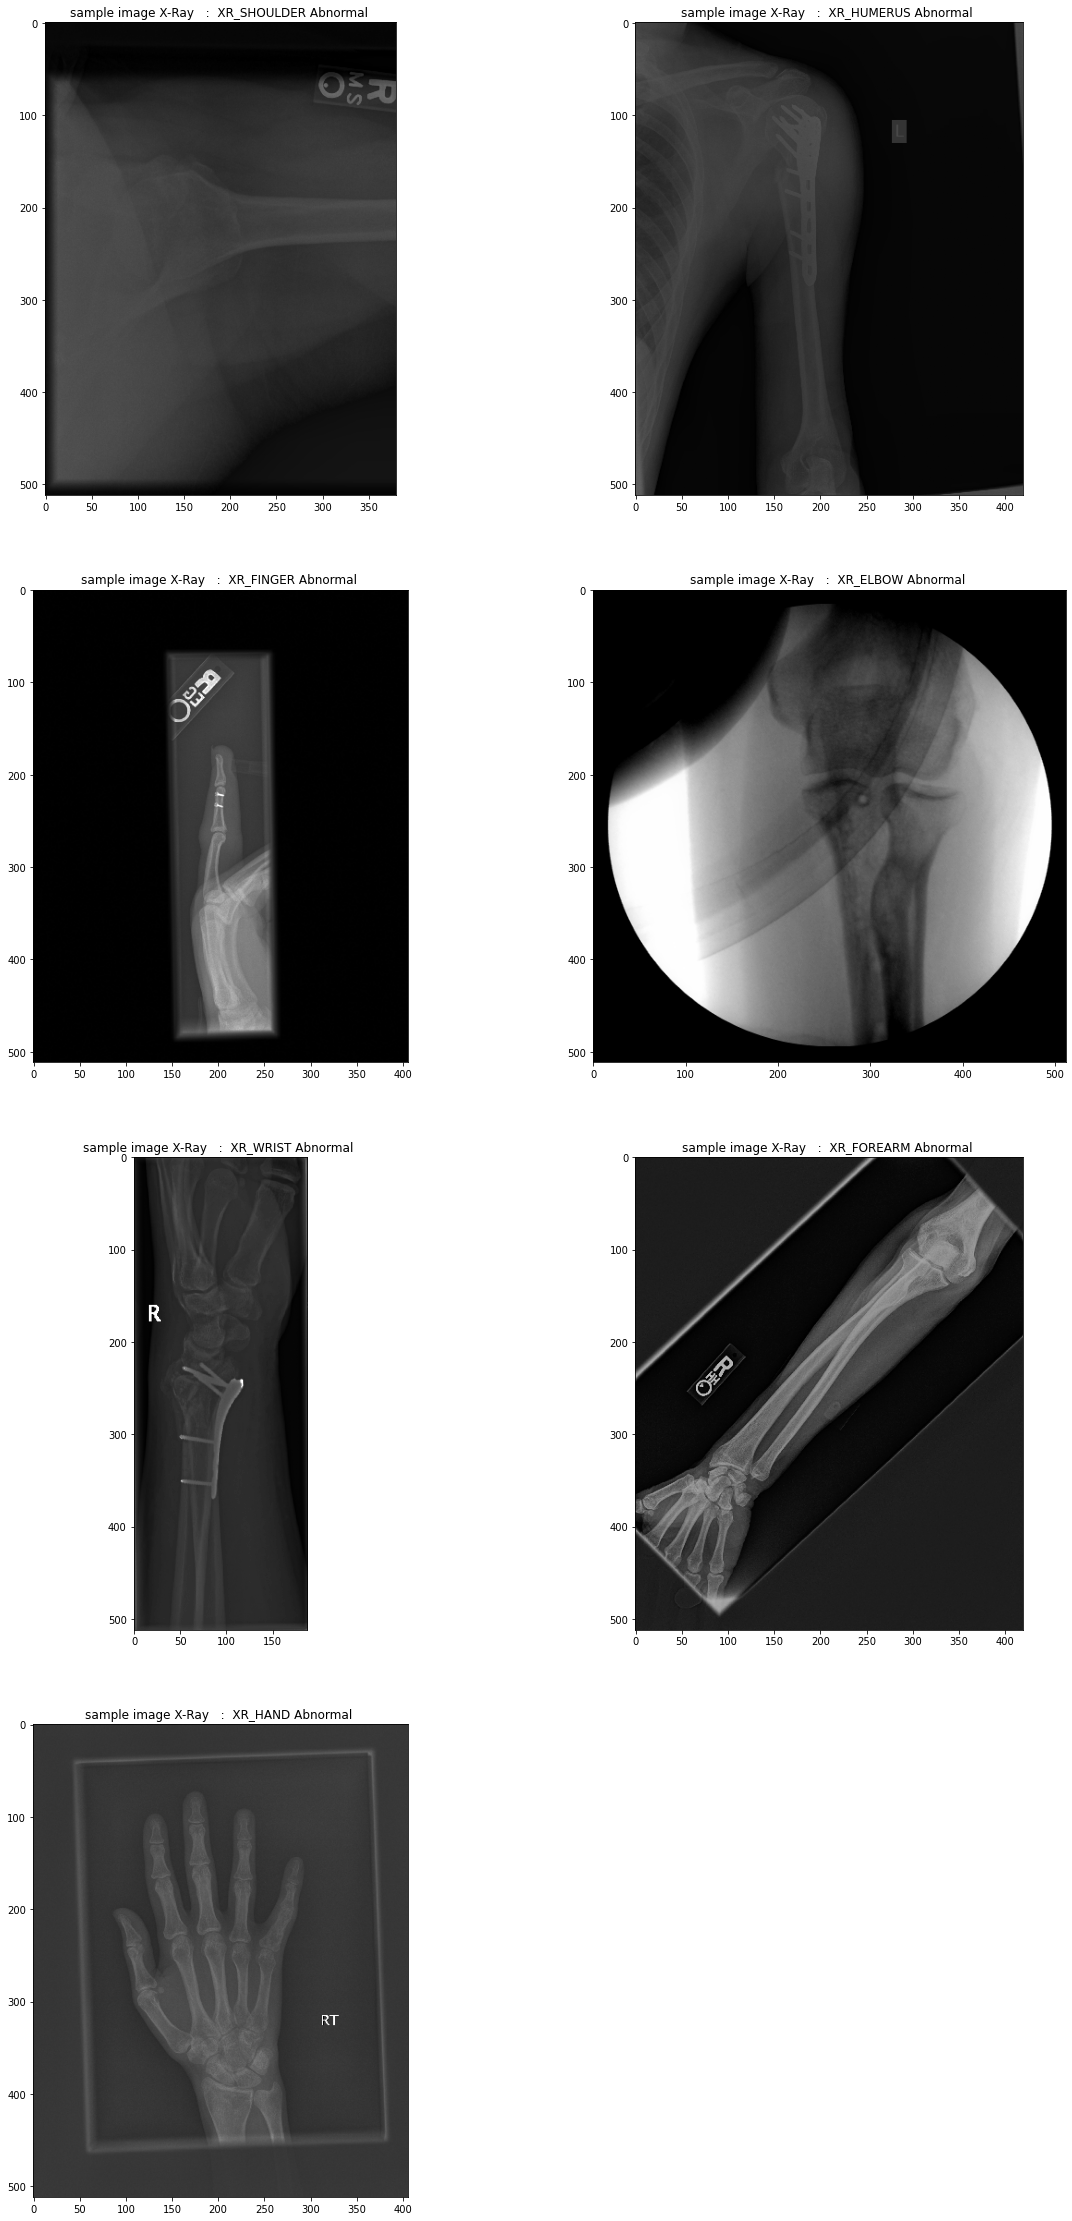

In [457]:
plt.figure(1,figsize=(20,40))
it = 0
for i in train.body_part.unique():
  plt.subplot(421+it)
  k=train[(train['body_part']==i)&(train['target']==1)]
  #img =open_image(path/k.path.iloc[0])
  img = mmg.imread(str(path/k.path.iloc[0]))
  plt.imshow(img,cmap='gray')
  shp = " ".join(str(x) for x in list(img.shape))
  plt.title('sample image X-Ray   :  ' +i + " Abnormal ")
  it+=1